In [469]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.05, 1.05]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [470]:
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)

model.copula_parameters = [0.5]

## Sobol indices with a classical Monte-Carlo sampling

In [478]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 1000
No = 100
Ni = 3

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)

In [479]:
n_boot = 500
Sh, Vsob, Tsob = shapley.compute_indices(n_boot=n_boot)

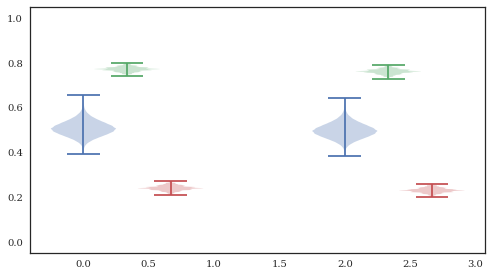

In [480]:
fig, ax = plt.subplots(figsize=(7, 4))

x = np.linspace(0, dim, dim)
ax.violinplot(Sh.reshape(dim, -1).T, x);
ax.violinplot(Vsob.reshape(dim, -1).T, x+1./3);
ax.violinplot(Tsob.reshape(dim, -1).T, x+2./3);
ax.set_ylim(ylim)
fig.tight_layout()

## Krigin Model

In [481]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [483]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 1000
No = 100
Ni = 3
n_realization = 200

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Wall time: 1.58 s


In [ ]:
n_boot = 500
Sh, Vsob, Tsob = shapley_kriging.compute_indices(n_boot=n_boot)
Sh.reshape(dim, -1).mean(axis=1)

array([ 0.50428623,  0.49571377])

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

x = np.linspace(0, dim, dim)
ax.violinplot(Sh.reshape(dim, -1).T, x);
ax.violinplot(Vsob.reshape(dim, -1).T, x+1./3);
ax.violinplot(Tsob.reshape(dim, -1).T, x+2./3);
ax.set_ylim(ylim)
fig.tight_layout()

### Calcul of conditional mean and variance

In [21]:
def condMVN(mean, cov, dependent_ind, given_ind, X_given):
    """ Returns conditional mean and variance of X[dependent.ind] | X[given.ind] = X.given
    where X is multivariateNormal(mean = mean, covariance = cov)"""
    
    cov = np.array(cov)
    
    B = cov.take(dependent_ind, axis = 1)
    B = B[dependent_ind]
    
    C = cov.take(dependent_ind, axis = 1)
    C = C[given_ind]
    
    D = cov.take(given_ind, axis = 1)
    D = D[given_ind]
    
    CDinv = np.dot(np.transpose(C), np.linalg.inv(D))
    
    condMean = mean[dependent_ind] + np.dot(CDinv,(X_given - mean[given_ind]))
    condVar = B - np.dot(CDinv,C)
    condVar = ot.CovarianceMatrix(condVar)
    
    return condMean,condVar

### Generate conditional law

In [22]:
def r_condMVN(n, mean, cov, dependent_ind, given_ind, X_given):
    """ Function to simulate conditional gaussian distribution of X[dependent.ind] | X[given.ind] = X.given
    where X is multivariateNormal(mean = mean, covariance = cov)"""
    
    cond_mean,cond_var = condMVN(mean, cov, dependent_ind, given_ind, X_given)
    distribution = ot.Normal(cond_mean,cond_var)
    return distribution.getSample(n)

## Evaluation Shapley effects on linear gaussian model

### Ni = 3

In [23]:
from shapley.shapley import shapley_indices

In [31]:
def gaussian_model(X):
    return np.sum(X,1)

d = 2
moyenne = np.zeros(d)
cov = np.identity(d)
cov = ot.CovarianceMatrix(cov)

def Xall(n):
    distribution = ot.Normal(moyenne,cov)
    return distribution.getSample(n)

def Xcond(n, Sj, Sjc, xjc):
    if Sjc is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(Sj, axis = 1)
        cov_int = cov_int[Sj, :]        
        cov_int = ot.CovarianceMatrix(cov_int)
        distribution = ot.Normal(moyenne[Sj],cov_int)
        return distribution.getSample(n)
    else:
        return r_condMVN(n,mean = moyenne, cov = cov, dependent_ind = Sj, given_ind = Sjc, X_given = xjc)

In [76]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
# Exact method
method = 'exact'
m = None
Nv = 10000
No = 1000
Ni = 3

index = shapley_indices(method, m, gaussian_model, model.input_distribution, d, Nv, No, Ni)
print('Exact method \n' + str(index) + '\n\n')

Exact method 
                         S1        S2
Shapley effects    0.495758  0.504242
First order Sobol  0.479324  0.487808
Total Sobol        0.512192  0.520676




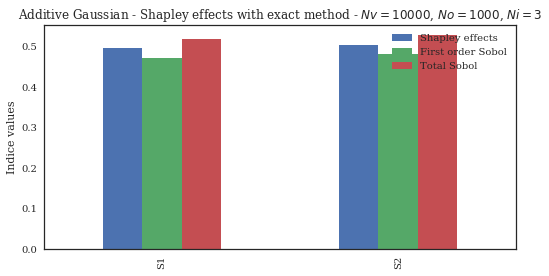

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))
index.T.plot(kind='bar', ax=ax)
ax.set_ylabel('Indice values')
ax.set_title("Additive Gaussian - Shapley effects with exact method - $Nv=%d$, $No=%d$, $Ni=%d$" % (Nv, No, Ni))

fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_shapley_exact.pdf')

In [ ]:
# Random method
method = 'random'
m = 6000
Nv = 10**4
No = 1
Ni = 3

index = shapley_indices(method,m,gaussian_model, Xall, Xcond, d, Nv, No, Ni)
print('Random method \n' + str(index) + '\n')

### Ni = 100

In [36]:
def gaussian_model(X):
    return np.sum(X,1)

d = 3
moyenne = np.zeros(3)
cov = np.array([[1.0, 0, 0], [0, 1.0, 1.8], [0, 1.8, 4.0]])
cov = ot.CovarianceMatrix(cov)

def Xall(n):
    distribution = ot.Normal(moyenne,cov)
    return distribution.getSample(n)

def Xcond(n, Sj, Sjc, xjc):
    if Sjc is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(Sj, axis = 1)
        cov_int = cov_int[Sj]        
        cov_int = ot.CovarianceMatrix(cov_int)
        distribution = ot.Normal(moyenne[Sj],cov_int)
        return distribution.getSample(n)
    else:
        return r_condMVN(n,mean = moyenne, cov = cov, dependent_ind = Sj, given_ind = Sjc, X_given = xjc)

# Exact method
method = 'exact'
m = None
Nv = 10**4
No = 10**3
Ni = 100

index = shapley_indices(method,m,gaussian_model, Xall, Xcond, d, Nv, No, Ni)
print('Exact method \n' + str(index) + '\n\n')

# Random method
method = 'random'
m = 6000
Nv = 10**4
No = 1
Ni = 100

index = shapley_indices(method,m,gaussian_model, Xall, Xcond, d, Nv, No, Ni)
print('Random method \n' + str(index) + '\n')

Exact method 
                         X1        X2        X3
Shapley effects    0.111180  0.416338  0.472482
First order Sobol  0.130968  0.821245  0.879474
Total Sobol        0.100965  0.019239  0.076484


Random method 
                         X1        X2        X3
Shapley effects    0.101384  0.411461  0.487155
First order Sobol  0.091213  0.813746  0.873265
Total Sobol        0.106143  0.020037  0.080028

